In [19]:
import math

import cufflinks as cf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPYNBrenderer import render_google_doc
from tensorflow import keras
import tensorflow as tf
cf.go_offline(connected=True)

$$ \ s_{current} = \beta s + (1- \beta) (\frac{\partial c}{\partial w _{((w)}})^2 

$$ \ w_{new} = w_{current} - \eta (\frac{\partial c}{\partial w _{((w)}}) * \sqrt{(s_{current} + \epsilon)}

In [2]:
def MSE_loss(target_y, predicted_y):
  error = target_y - predicted_y
  squared_error = tf.square(error)
  mse = tf.reduce_mean(squared_error)
  return mse

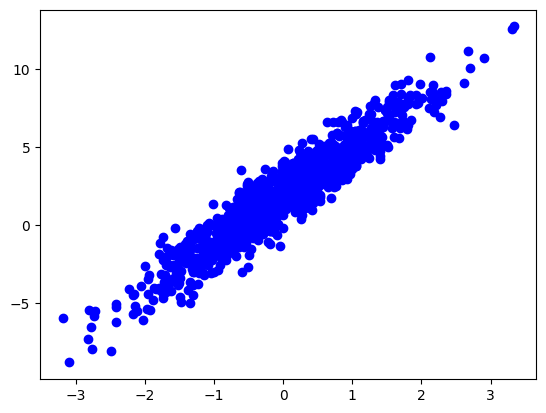

In [20]:
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 1000


x = tf.random.normal(shape=[NUM_EXAMPLES])
noise = tf.random.normal(shape=[NUM_EXAMPLES])
y = x * TRUE_W + TRUE_B + noise

plt.scatter(x, y, c='b')

In [4]:
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

    # initial weights
    self.w = tf.Variable(5.0) # TRUE_W = 3.0
    self.b = tf.Variable(0.0) # TRUE_B = 2.0
    self.w_s = tf.Variable(0.0)
    self.b_s =  tf.Variable(0.0)

  def __call__(self, x):
    return (self.w*x + self.b)

In [5]:
model = MyModel()

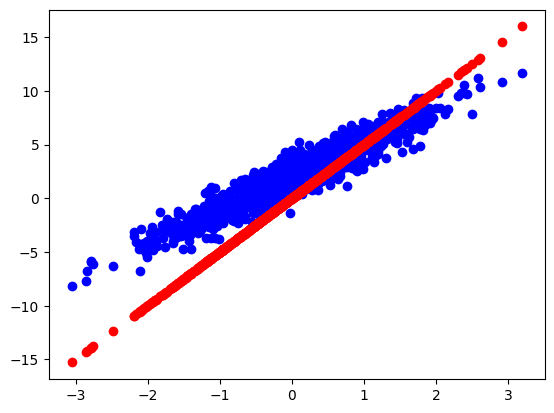

In [6]:
plt.scatter(x, y, c="b")

pred_y = model(x) # its an untrained model
plt.scatter(x, pred_y, c="r")

plt.show()


In [7]:
def RMSProp_optimizer_train(model, x, y, learning_rate , epsilon=1e-5 , momentum= 0.9):

  with tf.GradientTape(persistent=True) as tape:
    y_hat= model(x)
    current_loss = MSE_loss(y, y_hat)

  dc_dw, dc_db = tape.gradient(current_loss, [model.w, model.b])
  sw_new = model.w_s * momentum + tf.square(dc_dw)*(1-momentum)
  sb_new = model.b_s * momentum + tf.square(dc_db)*(1-momentum)

  model.w.assign_sub((learning_rate*dc_dw ) / tf.sqrt(sw_new + epsilon)) 
  model.b.assign_sub((learning_rate*dc_db) / tf.sqrt(sw_new + epsilon)) 
  model.b_s.assign(sb_new)
  model.w_s.assign(sw_new)
  return current_loss

In [8]:
model = MyModel()

Ws, bs , sw , sb  = list(), list() , list() , list()
LOSS = list()
epochs = 30

learning_rate = 0.9 # LARGE LEARNING RATE

w = model.w.numpy()
b = model.b.numpy()

init_loss = MSE_loss(y, model(x)).numpy()

print(f"initial W: {w}, initial_bias: {b}, initial loss: {init_loss}")

initial W: 5.0, initial_bias: 0.0, initial loss: 8.589447975158691


In [9]:
for epoch in range(epochs):
  RMSProp_optimizer_train(model, x, y, learning_rate )

  Ws.append(model.w.numpy())
  bs.append(model.b.numpy())
  sw.append(model.w_s.numpy())
  sb.append(model.b_s.numpy())
  current_loss = MSE_loss(y, model(x))
  LOSS.append(current_loss.numpy())

  print(f"For epoch: {epoch}, W: {Ws[-1]}, bias: {bs[-1]}, current loss: {current_loss}")

For epoch: 0, W: 2.1539604663848877, bias: 3.062340259552002, current loss: 2.802699565887451
For epoch: 1, W: 3.4021987915039062, bias: 1.5585825443267822, current loss: 1.268688440322876
For epoch: 2, W: 2.9046342372894287, bias: 2.2448959350585938, current loss: 1.0180009603500366
For epoch: 3, W: 3.1314890384674072, bias: 1.887359380722046, current loss: 0.9673845767974854
For epoch: 4, W: 3.0111629962921143, bias: 2.1031477451324463, current loss: 0.9541819095611572
For epoch: 5, W: 3.084707498550415, bias: 1.953542709350586, current loss: 0.9499287605285645
For epoch: 6, W: 3.0334858894348145, bias: 2.071506977081299, current loss: 0.9483914971351624
For epoch: 7, W: 3.0737359523773193, bias: 1.966637372970581, current loss: 0.9479377269744873
For epoch: 8, W: 3.0383522510528564, bias: 2.070974111557007, current loss: 0.9481565356254578
For epoch: 9, W: 3.0728964805603027, bias: 1.9555226564407349, current loss: 0.9491608142852783
For epoch: 10, W: 3.0356857776641846, bias: 2.096

In [10]:
data = pd.DataFrame({"W": Ws, "b": bs, "sw": sw, "sb": sb})

In [11]:
data["w_true"] = TRUE_W
data["b_true"] = TRUE_B

In [12]:
data['epoch'] = range(epochs)
data['loss'] = LOSS

In [13]:
data.iplot(kind="scatter" , x="epoch", y=["W" , "b" , "w_true" , "b_true"], mode="lines+markers", title="W vs epoch")

In [14]:
data.iplot(kind="scatter" , x="epoch", y=["loss" , "W" , "b"], mode="lines+markers", title="W vs epoch")

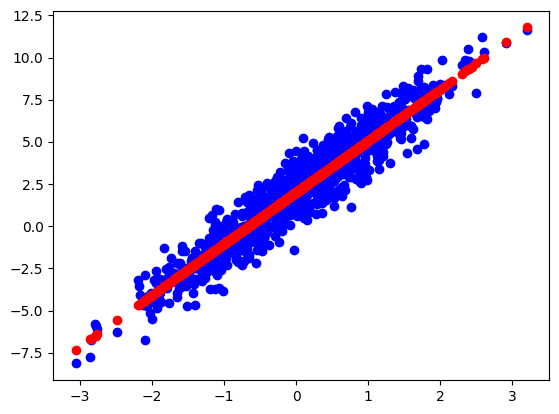

In [15]:
plt.scatter(x, y, c="b")

pred_y = model(x) # its an untrained model
plt.scatter(x, pred_y, c="r")

plt.show()

In [16]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full/255
X_test = X_test /255
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [17]:
import os


TENSOR_LOG_PATH = os.path.join(os.getcwd() , "TENSOR_BOARD_LOG")
os.makedirs(TENSOR_LOG_PATH , exist_ok=True )

In [18]:
%%timeit
LAYERS = [ tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(),
    
    tf.keras.layers.Dense(10, activation="softmax")]
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2,mode="min" ,monitor='val_loss',restore_best_weights=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(TENSOR_LOG_PATH)
model_normalized_batch= tf.keras.models.Sequential(LAYERS)
OPTIMIZER = tf.keras.optimizers.RMSprop(learning_rate=0.001 , rho=0.9)
model_normalized_batch.compile(loss="sparse_categorical_crossentropy", optimizer=OPTIMIZER , metrics=["accuracy"])
history = model_normalized_batch.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb , tensorboard_cb])

Epoch 1/100
  43/1719 [..............................] - ETA: 6s - loss: 0.9614 - accuracy: 0.6802

2022-10-23 23:41:34.628415: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1719/1719 [==============================] - 18s 10ms/step - loss: 0.4950 - accuracy: 0.8241 - val_loss: 0.3906 - val_accuracy: 0.8632
Epoch 2/100
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3839 - accuracy: 0.8596 - val_loss: 0.3634 - val_accuracy: 0.8716
Epoch 3/100
1719/1719 [==============================] - 22s 13ms/step - loss: 0.3485 - accuracy: 0.8729 - val_loss: 0.3459 - val_accuracy: 0.8838
Epoch 4/100
1719/1719 [==============================] - 31s 18ms/step - loss: 0.3296 - accuracy: 0.8796 - val_loss: 0.3365 - val_accuracy: 0.8816
Epoch 5/100
1719/1719 [==============================] - 31s 18ms/step - loss: 0.3125 - accuracy: 0.8847 - val_loss: 0.3582 - val_accuracy: 0.8782
Epoch 6/100
1719/1719 [==============================] - 30s 17ms/step - loss: 0.3000 - accuracy: 0.8910 - val_loss: 0.3356 - val_accuracy: 0.8834
Epoch 7/100
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2892 - accuracy: 0.8928 - val_loss: 0.3237 - val_

##   one of the best used optimizer used before ADAM



$ \beta $ is the only parameter to tune but $ \beta $ = 0.9 works fine 

RMSprop was able to slove adagrad abd ealy stopping problem 

